**GBP USD Currency forecasting**

Install the dependencies

In [21]:
%pip install numpy pandas scikit-learn matplotlib keras tensorflow

Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import SimpleRNN

# Load data
data = pd.read_csv('GBPUSD_5 Mins_Ask_2022.01.01_2023.12.31.csv')
data.head(5)


,Time (EET),Open,High,Low,Close,Volume
0,2022.01.03 00:00:00,1.35356,1.35357,1.35348,1.35348,12.22
1,2022.01.03 00:05:00,1.35348,1.35348,1.35348,1.35348,0.37
2,2022.01.03 00:10:00,1.35348,1.35382,1.35348,1.35367,7.41
3,2022.01.03 00:15:00,1.35367,1.35367,1.35367,1.35367,1.40
4,2022.01.03 00:20:00,1.35347,1.35363,1.35347,1.35363,0.70


Replace categorical data with one-hot encoded data

In [23]:
Data = data["Close"]
Data = pd.DataFrame(Data)
print(type(Data))
Data.head(5)

<class 'pandas.core.frame.DataFrame'>


,Close
0,1.35348
1,1.35348
2,1.35367
3,1.35367
4,1.35363


text

In [24]:
from sklearn import preprocessing
# Scaled data such that it is centered at 0 with unit variance.
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaledData = scaler.fit_transform(Data)

# Load volume data
volume_data = data['Volume']
volume_data = pd.DataFrame(volume_data)

# Scale volume data
volume_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_volume_data = volume_scaler.fit_transform(volume_data)

# Concatenate price and volume data
merged_data = pd.concat([pd.DataFrame(scaledData), pd.DataFrame(scaled_volume_data)], axis=1)


These prices will be separated into a **training set** and a **testing set** and **validation set**.

In [25]:
train = scaledData[:100000]
validation = scaledData[100000:110000]
test = scaledData[110000:]

print(train.shape)
print(validation.shape)
print(test.shape)

(100000, 1)
(10000, 1)
(39580, 1)


Currently, **train** and **test** are long sequences of stock prices.


We would like to convert these sequences into **x** and **y** sets, where **x** represents a sequence of prices and **y** is the **next price.**

Consider the following sequence:

We would want to generate the following sequences, in this case with a **window size of three.**

This can be recreated using the **TimeseriesGenerator**:

## TimeseriesGenerator 


Utility class for generating batches of temporal data.

This class takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as stride, length of history, etc., to produce batches for training/validation.

### Arguments

- **data:** Indexable generator (such as list or Numpy array) containing consecutive data points (timesteps). The data should be at 2D, and axis 0 is expected to be the time dimension.
- **targets:** Targets corresponding to timesteps in data. It should have same length as data.
- **length:** Length of the output sequences (in number of timesteps).
- **sampling_rate:** Period between successive individual timesteps within sequences. For rate r, timesteps data[i], data[i-r], ... data[i - length] are used for create a sample sequence.
- **stride:** Period between successive output sequences. For stride s, consecutive output samples would be centered around data[i], data[i+s], data[i+2*s], etc.
- **shuffle:** Whether to shuffle output samples, or instead draw them in chronological order.
- **reverse:** Boolean: if true, timesteps in each output sample will be in reverse chronological order.
- **batch_size:** Number of timeseries samples in each batch (except maybe the last one).


In [26]:
from keras.preprocessing.sequence import TimeseriesGenerator

trainGen = TimeseriesGenerator(data=train,targets=train,length=5,
                              sampling_rate=1,stride=1,
                              shuffle=False,reverse=False,
                              batch_size=8)

valGen = TimeseriesGenerator(data=validation,targets=validation,length=5,
                              sampling_rate=1,stride=1,
                              shuffle=False,reverse=False,
                              batch_size=8)
testGen = TimeseriesGenerator(data=test,targets=test,length=5,
                              sampling_rate=1,stride=1,
                              shuffle=False,reverse=False,
                              batch_size=8)

## Constructing a Simple Recurrent Neural Network

Now that the training data has been created, we can get started constructing the recurrent neural network. 

The simplest **RNN** has two layers:

- A standard recurrent layer 
- A standard dense layer, which will be connected through a Sequential model.



We can begin creating a **recurrent neural network** now.

Although it’s not entirely accurate, one can think of the **32** in **SimpleRNN(32, …)** as having **32 neurons**, much like a **dense layer.**

Since we are **predicting single values** on a continuous scale, the last **dense layer** has one neuron and a linear activation.



Because our sequences have **5 elements** and each can be represented using only **one value,** the input shape of a sequence is (5, 1).



In [27]:
# Designing Simple RNN Model 

GBPUSD = Sequential()
#simple recurrent layer, 32 neurons & process 5x1 sequences
GBPUSD.add(SimpleRNN(32, return_sequences=False, input_shape=(5,1))) 
#linear output because this is a regression problem
GBPUSD.add(Dense(1,activation='linear')) 
print(GBPUSD.summary()) 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Designing LSTM RNN Model 

In [28]:
# Designing LSTM RNN Model 

GBPUSD = Sequential()
GBPUSD.add(LSTM(32,return_sequences=False,input_shape=(5,1)))
GBPUSD.add(Dense(1))
print(GBPUSD.summary()) 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Stacking multiple recurrent layers

A **single recurrent layer** can be thought of as parsing several inputs, taking into account sequential order and find the **derivatives (rates of changes)** and infer a generalizable pattern across sequences. 

**NOTE:** We can only pick up linear changes.
    
Stacking two or more recurrent layers, then, is like taking a **double derivative,** or the **‘difference of the difference’**. Much like **stacking multiple convolutional layers,** it allows for more **complex relationships** to be identified.

If you want to stack **two recurrent layers** SET the parameter  **return_sequences=True**.

This returns the **output** as a **sequence** that can be **inputted into another recurrent layer.**

We may decide to design a deep recurrent neural network with several stacked layers as follows:

In [29]:
GBPUSD = Sequential() #initialize the model
GBPUSD.add(SimpleRNN(64, input_shape=(5,1), return_sequences=True)) #recurrent layer 1, 64 neurons
GBPUSD.add(SimpleRNN(32, return_sequences=False)) #recurrent layer 2, 32 neurons

GBPUSD.add(Dense(8,activation='tanh')) #Dense layer, 8 neurons w/ tanh activation
GBPUSD.add(Dense(1,activation='linear')) #output dense layer (1 neuron) w/ linear activation
print(GBPUSD.summary())


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 5, 64)             4224      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_10 (Dense)            (None, 8)                 264       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 7601 (29.69 KB)
Trainable params: 7601 (29.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Lastly, the Keras model must be **compiled** with a loss (mean absolute error for regression), an optimizer (Adam), and optional metrics to track the progress (**mae** and **mse**).

We’ll train the model on **trainGen** and **validation_data** for **50 epochs** and save training data to **history.**

In [30]:

GBPUSD.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mae','mse'])
history = GBPUSD.fit_generator(trainGen,validation_data=valGen, epochs=10,verbose = 1)

Epoch 1/10


/var/folders/jl/4g54d1z131j0xvv_vmwbzy0c0000gn/T/ipykernel_21242/2540032903.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = GBPUSD.fit_generator(trainGen,validation_data=valGen, epochs=10,verbose = 1)


12500/12500 [==============================] - 22s 2ms/step - loss: 0.0171 - mae: 0.0171 - mse: 7.2533e-04 - val_loss: 0.0068 - val_mae: 0.0068 - val_mse: 4.7939e-05
Epoch 2/10
12500/12500 [==============================] - 19s 2ms/step - loss: 0.0085 - mae: 0.0085 - mse: 1.4429e-04 - val_loss: 0.0113 - val_mae: 0.0113 - val_mse: 1.3130e-04
Epoch 3/10
12500/12500 [==============================] - 19s 2ms/step - loss: 0.0064 - mae: 0.0064 - mse: 7.9205e-05 - val_loss: 0.0022 - val_mae: 0.0022 - val_mse: 6.6996e-06
Epoch 4/10
12500/12500 [==============================] - 20s 2ms/step - loss: 0.0053 - mae: 0.0053 - mse: 5.6168e-05 - val_loss: 0.0031 - val_mae: 0.0031 - val_mse: 1.1211e-05
Epoch 5/10
12500/12500 [==============================] - 20s 2ms/step - loss: 0.0047 - mae: 0.0047 - mse: 4.2427e-05 - val_loss: 0.0081 - val_mae: 0.0081 - val_mse: 6.9073e-05
Epoch 6/10
12500/12500 [==============================] - 19s 2ms/step - loss: 0.0042 - mae: 0.0042 - mse: 3.3800e-05 - val_lo

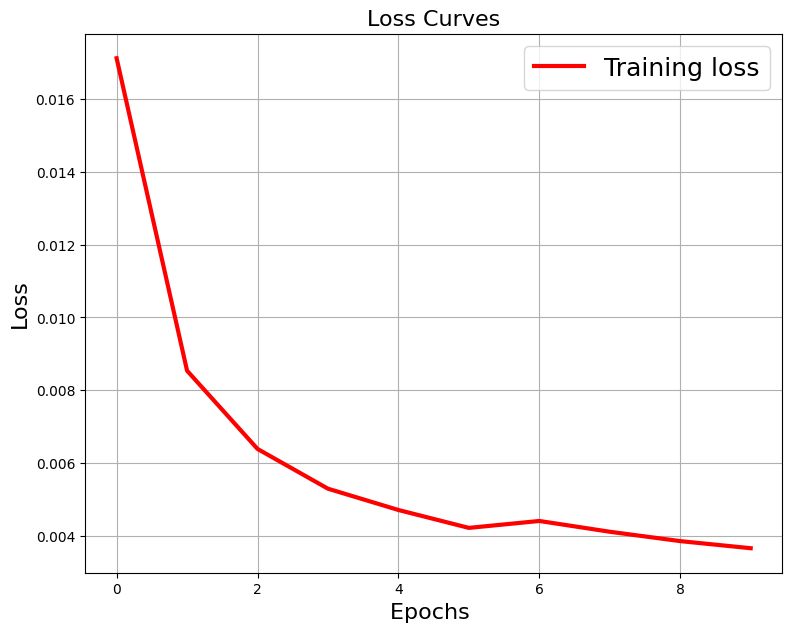

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[9,7])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.grid(True)

In [32]:
# Predicting and undoing the scaling #
predictions = GBPUSD.predict_generator(testGen)
predictions = scaler.inverse_transform(predictions)
test = scaler.inverse_transform(test)

/var/folders/jl/4g54d1z131j0xvv_vmwbzy0c0000gn/T/ipykernel_21242/3618604800.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = GBPUSD.predict_generator(testGen)


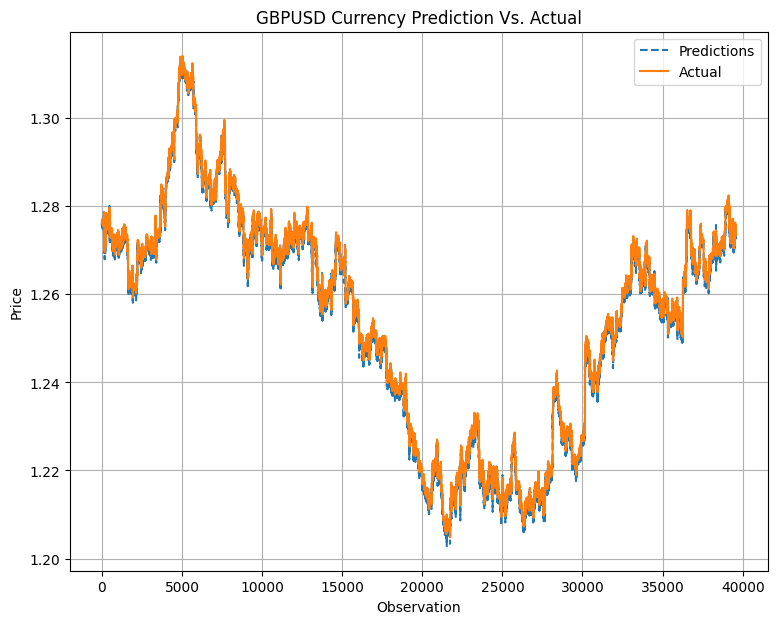

In [33]:
plt.figure(figsize=[9,7])
plt.plot(predictions,'--',label='Predictions')
plt.plot(test,label='Actual')
plt.xlabel("Observation")
plt.ylabel("Price")
plt.title("GBPUSD Currency Prediction Vs. Actual")
plt.legend()
plt.grid(True)
plt.show()